## Les librairies

In [1]:
!pip install livelossplot

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import joblib
import keras

from PIL import Image, ImageFilter, ImageEnhance
from livelossplot import PlotLossesKeras
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, img_to_array
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten, Dropout,BatchNormalization
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = '/kaggle/input/mmu-iris-database/MMU-Iris-Database'
img_dim=(240,320,3)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Les fonctions

In [2]:
# Prétraitement de l'image : redimensionnemennt et standardisation
def preprocess_img(img: list, new_dim: tuple = (240, 320)):
    new_img = cv2.resize(
        img, (new_dim[1], new_dim[0]), interpolation=cv2.INTER_AREA)
    new_img = new_img / 255.0
    return new_img

# liste des imgs preprocess pour la répartition par côté
def liste_X_Y_side(main_folder: str, side_list: list, img_dim: tuple):
    X = []
    Y = []

    for target_folder in os.listdir(main_folder):
        target_path = os.path.join(main_folder, target_folder)

        if os.path.isdir(target_path):
            for side in side_list:
                side_path = os.path.join(target_path, side)
                if os.path.isdir(side_path):
                    for image_filename in os.listdir(side_path):
                        if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                            image_path = os.path.join(
                                side_path, image_filename)
                            target = int(target_folder)
                            image = preprocess_img(
                                cv2.imread(image_path), img_dim)
                            X.append(image)
                            Y.append(side)
    return X, Y

# liste des imgs preprocess pour chaque utilisateur
def liste_X_Y(main_folder: str, side_list: list, img_dim: tuple):
    X = []
    Y = []

    for target_folder in os.listdir(main_folder):
        target_path = os.path.join(main_folder, target_folder)

        if os.path.isdir(target_path):
            for side in side_list:
                side_path = os.path.join(target_path, side)
                if os.path.isdir(side_path):
                    for image_filename in os.listdir(side_path):
                        if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                            image_path = os.path.join(
                                side_path, image_filename)
                            target = int(target_folder)
                            image = preprocess_img(
                                cv2.imread(image_path), img_dim)
                            X.append(image)
                            Y.append(target)
    return X, Y

def data_augmentation(datagen, data_x: list, data_y: list, factor: int):
    x_aug = []
    y_aug = []

    for i in range(len(data_x)):
        x = img_to_array(data_x[i])
        x = x * 255.0
        x = np.expand_dims(x, axis=0)
        count = 0

        for batch in datagen.flow(x, batch_size=1):
            x_aug.append(batch[0]/255)
            y_aug.append(data_y[i])
            count += 1
            if count >= factor:
                break
    return x_aug, y_aug

# Oeil Gauche

## Récupération des images et préparation de la dataset pour l'oeil gauche

In [3]:
X_left, Y_left = liste_X_Y(main_folder, ['left'], img_dim)

In [4]:
pd.Series(Y_left).value_counts()

7     5
18    5
16    5
13    5
26    5
15    5
3     5
43    5
1     5
30    5
14    5
9     5
46    5
21    5
44    5
40    5
6     5
11    5
37    5
33    5
29    5
28    5
34    5
17    5
31    5
19    5
22    5
2     5
35    5
23    5
10    5
5     5
36    5
20    5
45    5
27    5
41    5
39    5
32    5
25    5
42    5
8     5
38    5
12    5
24    5
Name: count, dtype: int64

In [5]:
labelLeftEnc=preprocessing.LabelEncoder()
Y_left_enc=labelLeftEnc.fit_transform(Y_left)

In [6]:
# Split the data into training and testing sets while maintaining class distribution
X_left_train, X_left_test, y_left_train, y_left_test = train_test_split(X_left, Y_left_enc, test_size=0.2, random_state=42, stratify=Y_left_enc)

y_left_train_enc=to_categorical(y_left_train)
y_left_test_enc=to_categorical(y_left_test)

In [7]:
pd.Series(y_left_test).value_counts()

30    1
7     1
19    1
40    1
3     1
35    1
6     1
36    1
27    1
12    1
23    1
24    1
34    1
43    1
28    1
38    1
8     1
32    1
39    1
16    1
25    1
0     1
13    1
4     1
15    1
33    1
17    1
26    1
21    1
31    1
37    1
10    1
20    1
9     1
41    1
2     1
5     1
29    1
42    1
44    1
14    1
18    1
11    1
22    1
1     1
Name: count, dtype: int64

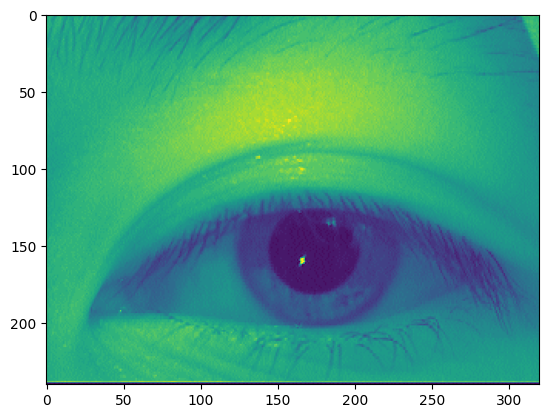

In [8]:
plt.imshow(X_left_train[0][:,:,2])

## Data augmentation de l'oeil gauche

In [9]:
# data augmentation pour oeil gauche
datagen_OG = ImageDataGenerator(
    rotation_range=5,  # rotation
    width_shift_range=0.05,  # déplacement horizontal
    height_shift_range=0.05,  # déplacement vertical
    zoom_range=0.2,  # zoom
    brightness_range=(0.8, 1.2),  # luminosité
    fill_mode='nearest',  # mode de remplissage
)

aug_X_left_train, aug_y_left_train = data_augmentation(datagen_OG, X_left_train, y_left_train_enc, 20)

X_left_train_aug = X_left_train.copy()
y_left_train_aug = y_left_train_enc.copy()

for i in range(len(aug_X_left_train)):
  X_left_train_aug.append(aug_X_left_train[i])
  y_left_train_aug = np.concatenate((y_left_train_aug, np.array([aug_y_left_train[i]])))

In [10]:
print('X_left_train', len(X_left_train))
print('X_left_train_aug', len(X_left_train_aug))
print('y_left_train_enc',len(y_left_train_enc))
print('y_left_train_aug',len(y_left_train_aug))

X_left_train 180
X_left_train_aug 3780
y_left_train_enc 180
y_left_train_aug 3780


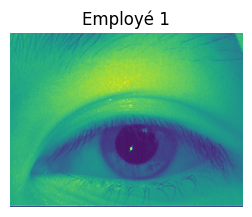

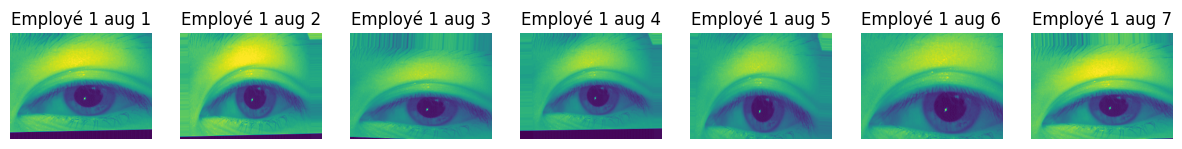

In [11]:
# image origine
plt.figure(figsize=(3,5))
plt.imshow(X_left_train[0][:,:,2])
plt.title(f'Employé 1')
plt.axis('off')
plt.show()

# Images transformées
plt.figure(figsize=(15, 5))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(aug_X_left_train[i][:,:,2])
    plt.title(f'Employé 1 aug {i+1}')
    plt.axis('off')
plt.show()

## Entrainement du modèle et affichage des performances pour l'oeil gauche

In [12]:
metric_stop = 'val_accuracy'
rlrop = ReduceLROnPlateau(monitor=metric_stop, factor=0.1, patience=3)
early = EarlyStopping(monitor=metric_stop,patience=5,restore_best_weights=True)

In [13]:
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

OG_model = create_model()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                              

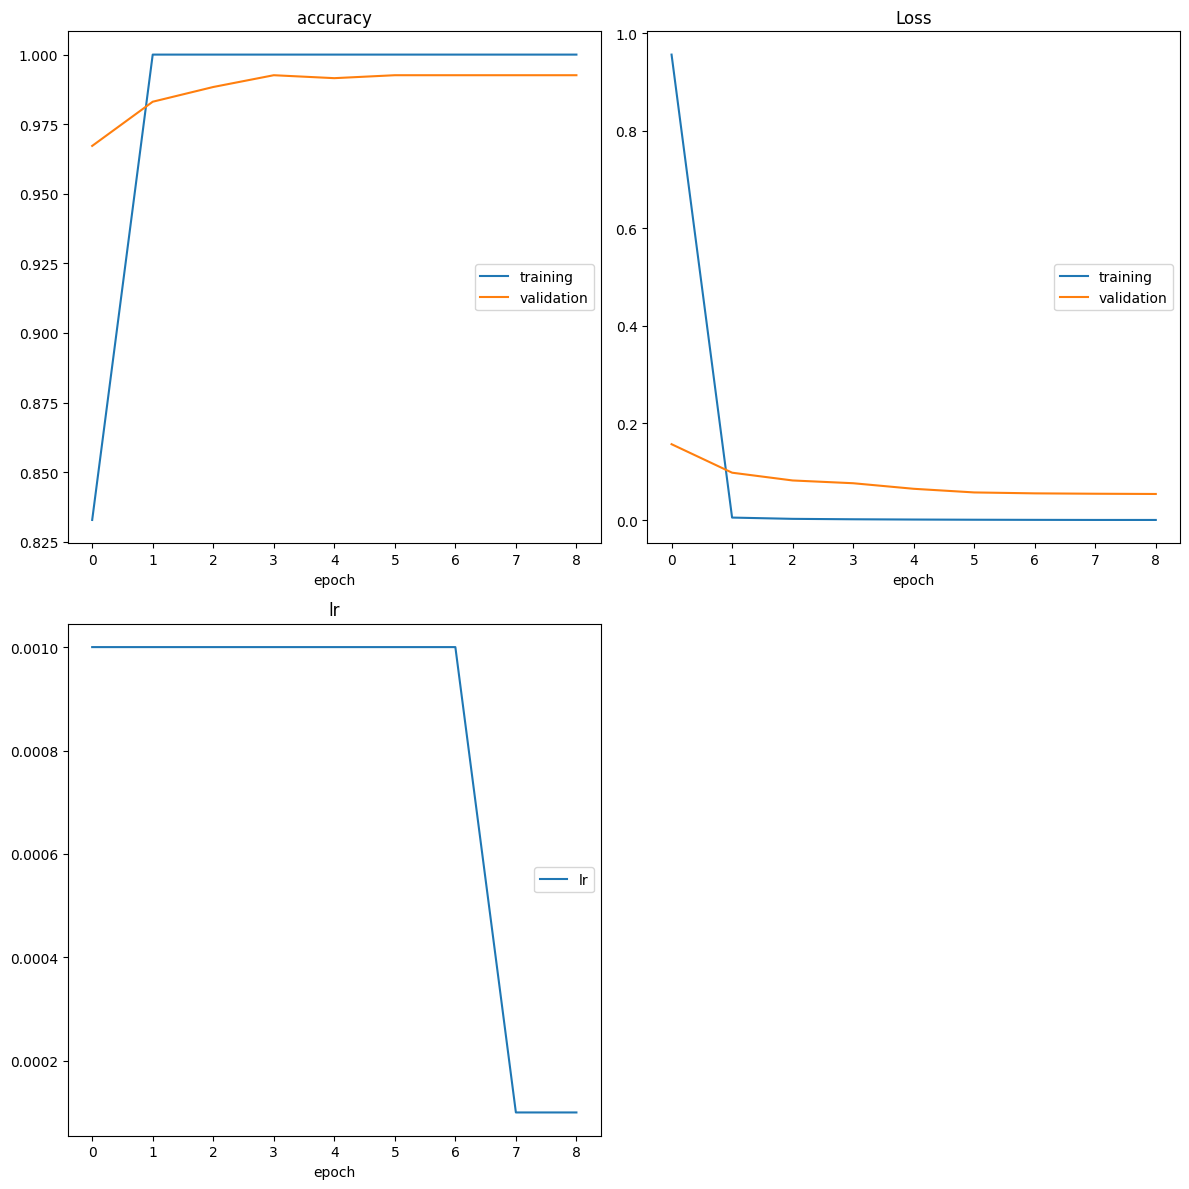

accuracy
	training         	 (min:    0.833, max:    1.000, cur:    1.000)
	validation       	 (min:    0.967, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.001, max:    0.956, cur:    0.001)
	validation       	 (min:    0.054, max:    0.157, cur:    0.054)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
95/95 [==============================] - 27s 280ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9926 - lr: 1.0000e-04


In [14]:
hist = OG_model.fit(np.array(X_left_train_aug), np.array(y_left_train_aug), batch_size=30,
                    epochs=100, validation_split=0.25, callbacks=[rlrop, early, PlotLossesKeras()])

## Métriques pour la reconnaissance de l'oeil gauche

In [15]:
aug_X_left_test, aug_y_left_test = data_augmentation(datagen_OG, X_left_test, y_left_test, 3)

X_left_test_aug = X_left_test.copy()
y_left_test_aug = y_left_test.copy()

for i in range(len(aug_X_left_test)):
  X_left_test_aug.append(aug_X_left_test[i])
  y_left_test_aug = np.concatenate((y_left_test_aug, np.array([aug_y_left_test[i]])))

y_left_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_left_test_aug))]  # Prédictions du modèle


6/6 [==============================] - 13s 1s/step


Matrice de confusion :
[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]
Précision : 0.97
Rappel : 0.96
Score F1 : 0.96
Exactitude : 0.96


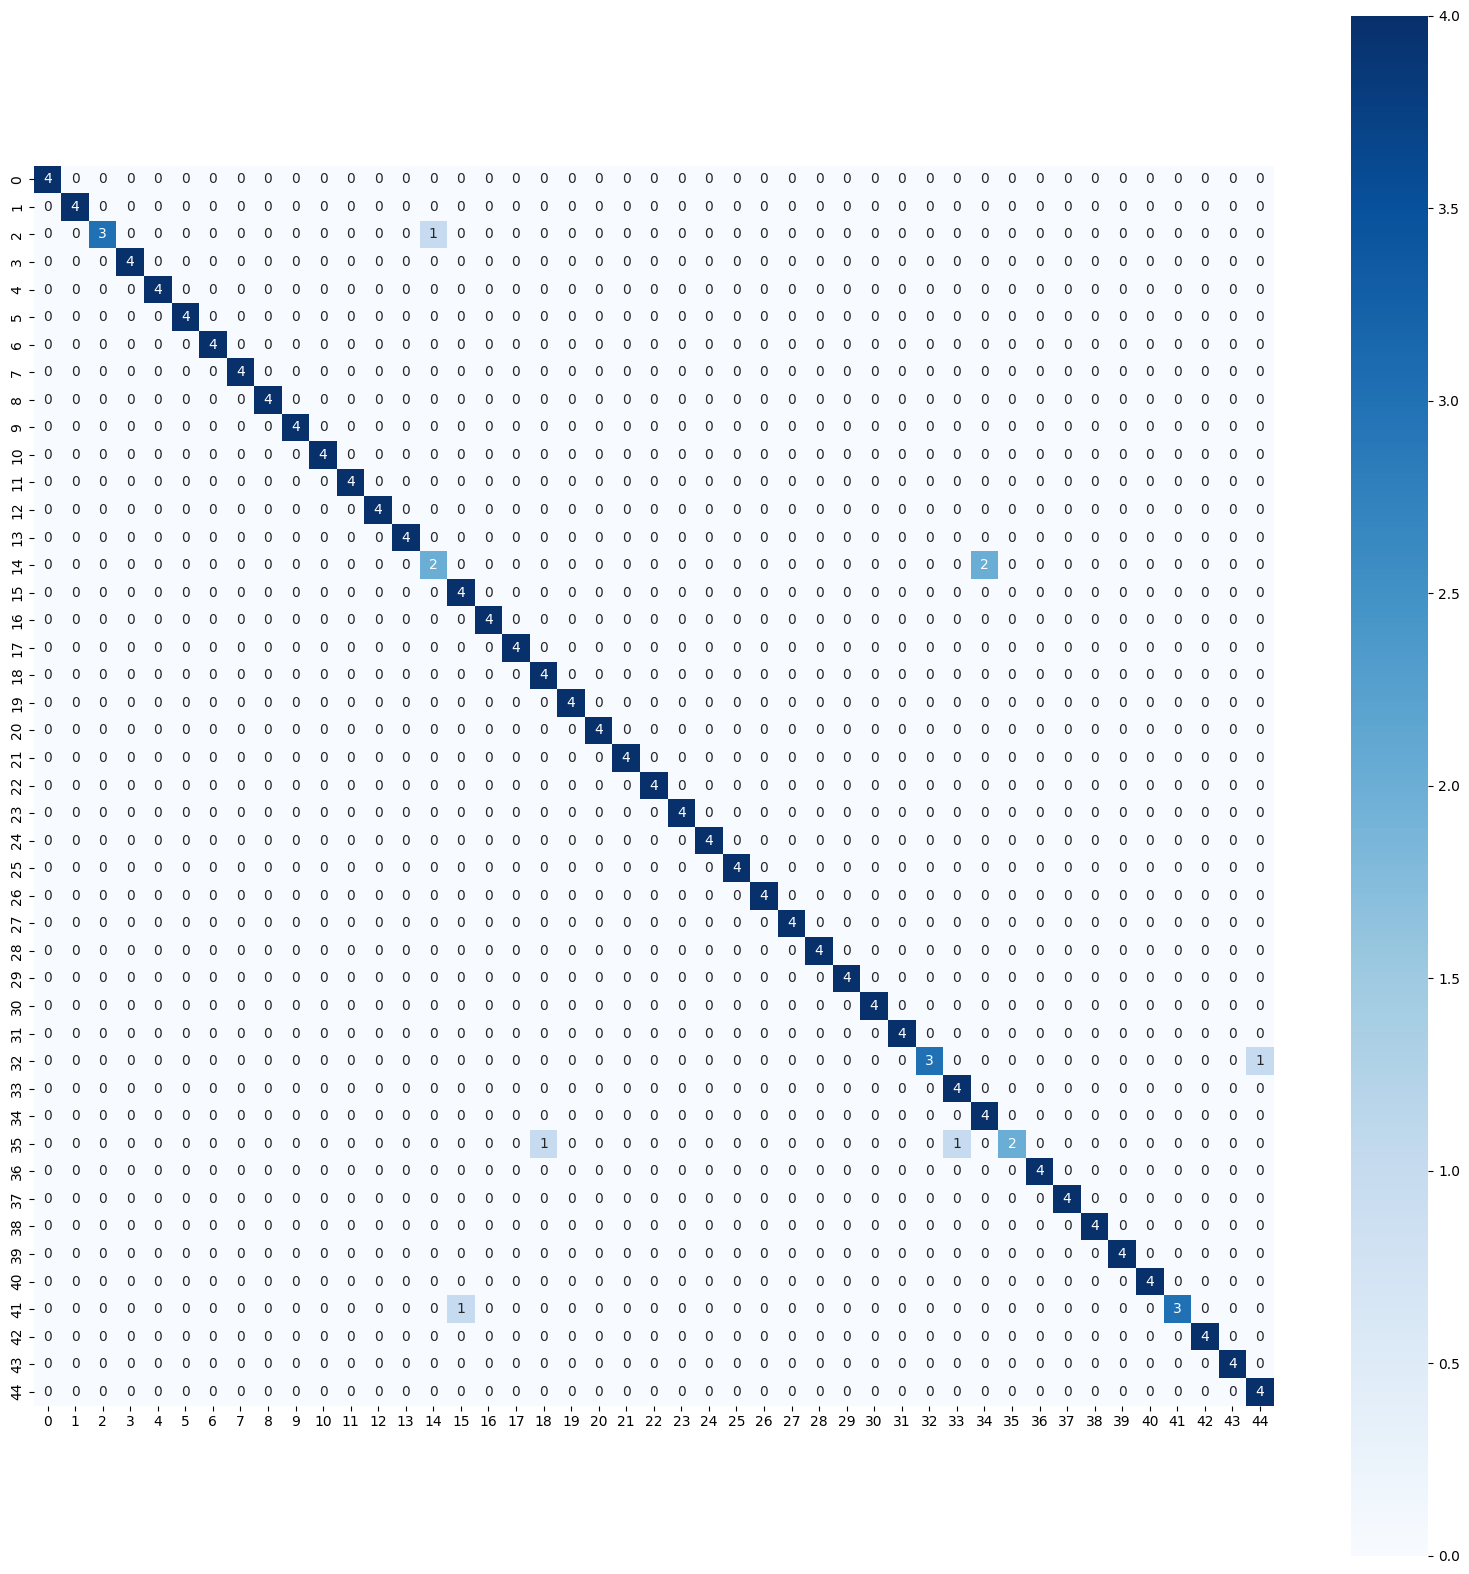

In [16]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_left_test_aug), np.array(y_left_test_pred))
plt.subplots(figsize=(20,20))
sns.heatmap(conf_matrix , annot=True,cmap='Blues')

# # Calcul des mesures de performance
accuracy = accuracy_score(y_left_test_aug, y_left_test_pred)
precision = precision_score(y_left_test_aug, y_left_test_pred,average='macro')
recall = recall_score(y_left_test_aug, y_left_test_pred,average='macro')
f1 = f1_score(y_left_test_aug, y_left_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

## Sauvegarde du modèle, de l'encodeur, de la data augmentation pour la reconnaisance de l'oeil gauche

In [17]:
joblib.dump(X_left_train_aug,"/kaggle/working/img_left_train.joblib")
joblib.dump(X_left_test_aug,"/kaggle/working/img_left_test.joblib")

['/kaggle/working/img_left_test.joblib']

In [18]:
OG_model.save("/kaggle/working/vgg16_side_OG2ID_classif")
joblib.dump(labelLeftEnc,"/kaggle/working/encodeur_OG.joblib")

['/kaggle/working/encodeur_OG.joblib']

# Oeil droit

## Récupération des images et préparation de la dataset pour l'oeil droit

In [19]:
X_right, Y_right = liste_X_Y(main_folder, ['right'], img_dim)

In [20]:
pd.Series(Y_right).value_counts()

7     5
18    5
16    5
13    5
26    5
15    5
3     5
43    5
1     5
30    5
14    5
9     5
46    5
21    5
44    5
40    5
6     5
11    5
37    5
33    5
29    5
28    5
34    5
17    5
31    5
19    5
22    5
2     5
35    5
23    5
10    5
5     5
36    5
20    5
45    5
27    5
41    5
39    5
32    5
25    5
42    5
8     5
38    5
12    5
24    5
Name: count, dtype: int64

In [21]:
labelRightEnc=preprocessing.LabelEncoder()
Y_right_enc=labelRightEnc.fit_transform(Y_right)

In [22]:
# Split the data into training and testing sets while maintaining class distribution
X_right_train, X_right_test, y_right_train, y_right_test = train_test_split(X_right, Y_right_enc, test_size=0.2, random_state=42, stratify=Y_right_enc)

y_right_train_enc=to_categorical(y_right_train)
y_right_test_enc=to_categorical(y_right_test)

In [23]:
print(len(X_right_train))
print(len(y_right_train))

180
180


In [24]:
pd.Series(y_right_test).value_counts()

30    1
7     1
19    1
40    1
3     1
35    1
6     1
36    1
27    1
12    1
23    1
24    1
34    1
43    1
28    1
38    1
8     1
32    1
39    1
16    1
25    1
0     1
13    1
4     1
15    1
33    1
17    1
26    1
21    1
31    1
37    1
10    1
20    1
9     1
41    1
2     1
5     1
29    1
42    1
44    1
14    1
18    1
11    1
22    1
1     1
Name: count, dtype: int64

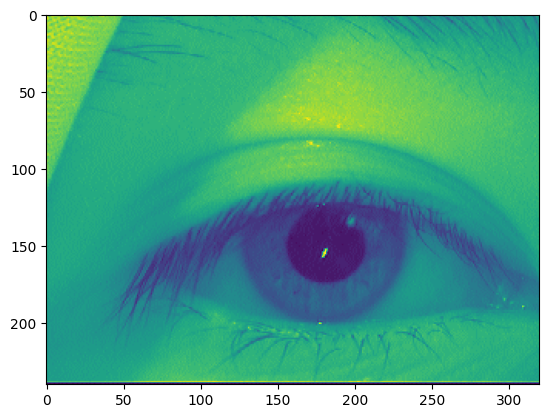

In [25]:
plt.imshow(X_right_train[0][:,:,2])

## Data augmentation de l'oeil droit

In [26]:
# data augmentation
datagen_OD = ImageDataGenerator(
    rotation_range=5,  # rotation
    width_shift_range=0.02,  # déplacement horizontal
    height_shift_range=0.02,  # déplacement vertical
    zoom_range=0.2,  # zoom
    brightness_range=(0.8, 1.2),  # luminosité
    fill_mode='nearest',  # mode de remplissage
)

aug_X_right_train, aug_y_right_train = data_augmentation(datagen_OD, X_right_train, y_right_train_enc, 20)

X_right_train_aug = X_right_train.copy()
y_right_train_aug = y_right_train_enc.copy()

for i in range(len(aug_X_right_train)):
  X_right_train_aug.append(aug_X_right_train[i])
  y_right_train_aug = np.concatenate((y_right_train_aug, np.array([aug_y_right_train[i]])))

In [27]:
print('X_right_train', len(X_right_train))
print('X_right_train_aug', len(X_right_train_aug))
print('y_right_train_enc',len(y_right_train_enc))
print('y_right_train_aug',len(y_right_train_aug))

X_right_train 180
X_right_train_aug 3780
y_right_train_enc 180
y_right_train_aug 3780


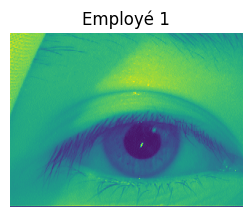

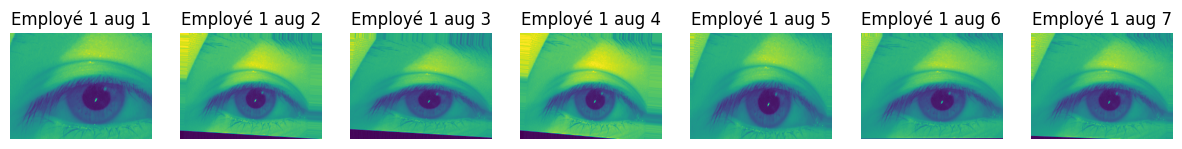

In [28]:
# image origine
plt.figure(figsize=(3,5))
plt.imshow(X_right_train[0][:,:,2])
plt.title(f'Employé 1')
plt.axis('off')
plt.show()

# Images transformées
plt.figure(figsize=(15, 5))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(aug_X_right_train[i][:,:,2])
    plt.title(f'Employé 1 aug {i+1}')
    plt.axis('off')
plt.show()

## Entrainement du modèle et affichage des performances pour l'oeil droit

In [29]:
metric_stop = 'val_accuracy'
rlrop = ReduceLROnPlateau(monitor=metric_stop, factor=0.1, patience=3)
early = EarlyStopping(monitor=metric_stop,patience=5,restore_best_weights=True)

In [30]:
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

OD_model = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

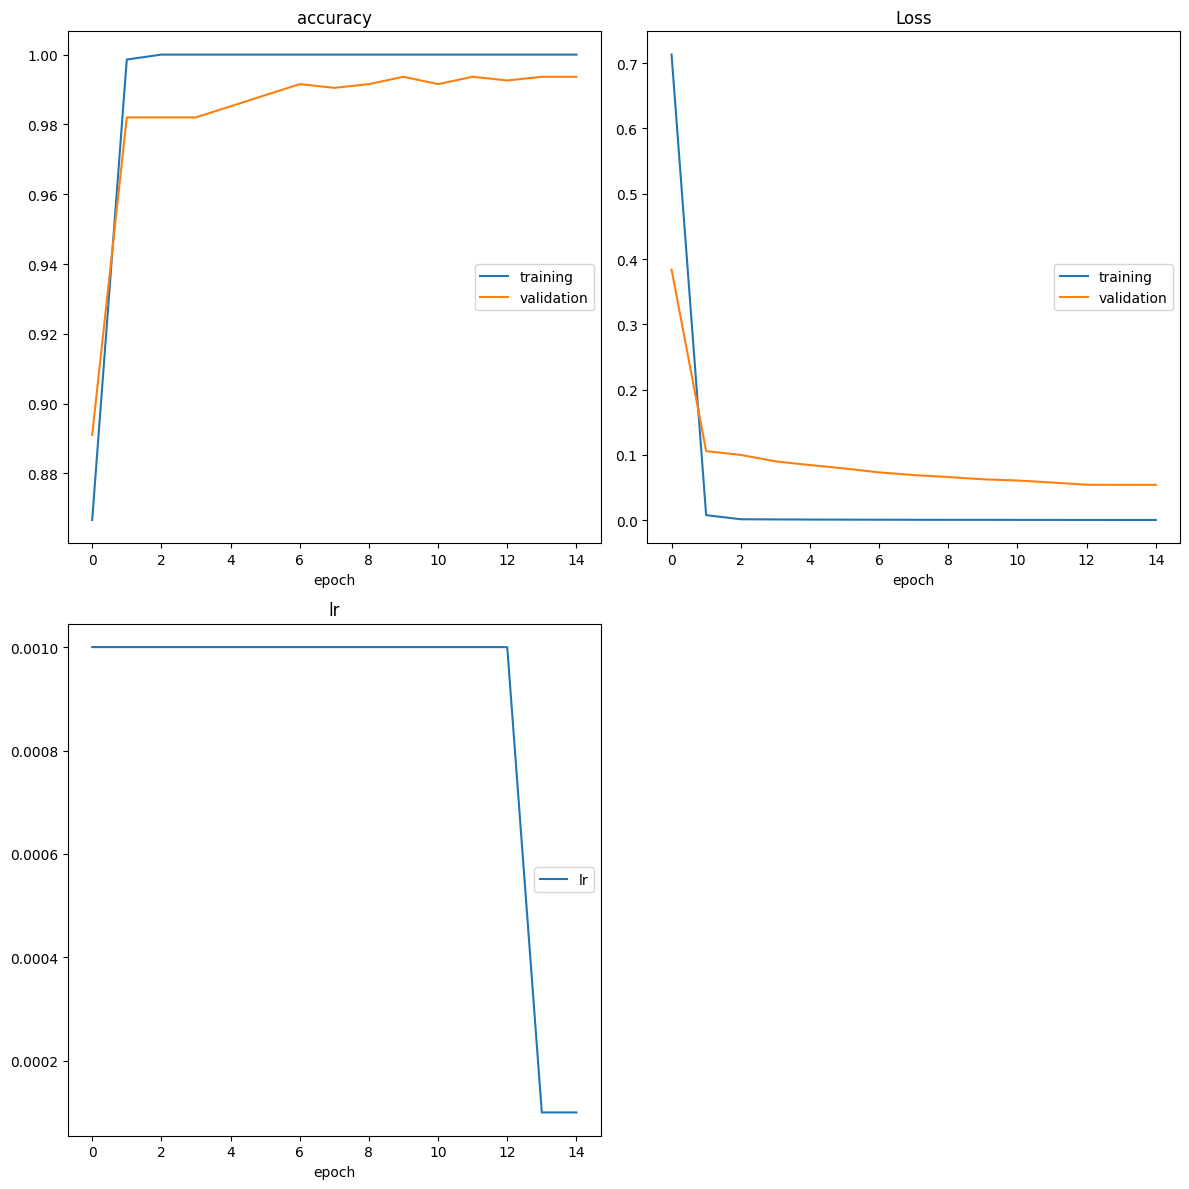

accuracy
	training         	 (min:    0.867, max:    1.000, cur:    1.000)
	validation       	 (min:    0.891, max:    0.994, cur:    0.994)
Loss
	training         	 (min:    0.000, max:    0.713, cur:    0.000)
	validation       	 (min:    0.054, max:    0.384, cur:    0.054)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
95/95 [==============================] - 27s 280ms/step - loss: 2.7827e-04 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9937 - lr: 1.0000e-04


In [31]:
hist = OD_model.fit(np.array(X_right_train_aug), np.array(y_right_train_aug), batch_size=30,
                    epochs=100, validation_split=0.25, callbacks=[rlrop, early, PlotLossesKeras()])

## Métriques pour la reconnaissance de l'oeil droit

In [32]:
aug_X_right_test, aug_y_right_test = data_augmentation(datagen_OD, X_right_test, y_right_test, 3)

X_right_test_aug = X_right_test.copy()
y_right_test_aug = y_right_test.copy()

for i in range(len(aug_X_right_test)):
  X_right_test_aug.append(aug_X_right_test[i])
  y_right_test_aug = np.concatenate((y_right_test_aug, np.array([aug_y_right_test[i]])))

y_right_test_pred = [np.argmax(v) for v in OD_model.predict(np.array(X_right_test_aug))]  # Prédictions du modèle

6/6 [==============================] - 1s 211ms/step


In [33]:
print(len(X_right_test))
print(len(y_right_test))

print(len(X_right_test_aug))
print(len(y_right_test_aug))

45
45
180
180


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]
Précision : 0.94
Rappel : 0.95
Score F1 : 0.94
Exactitude : 0.95


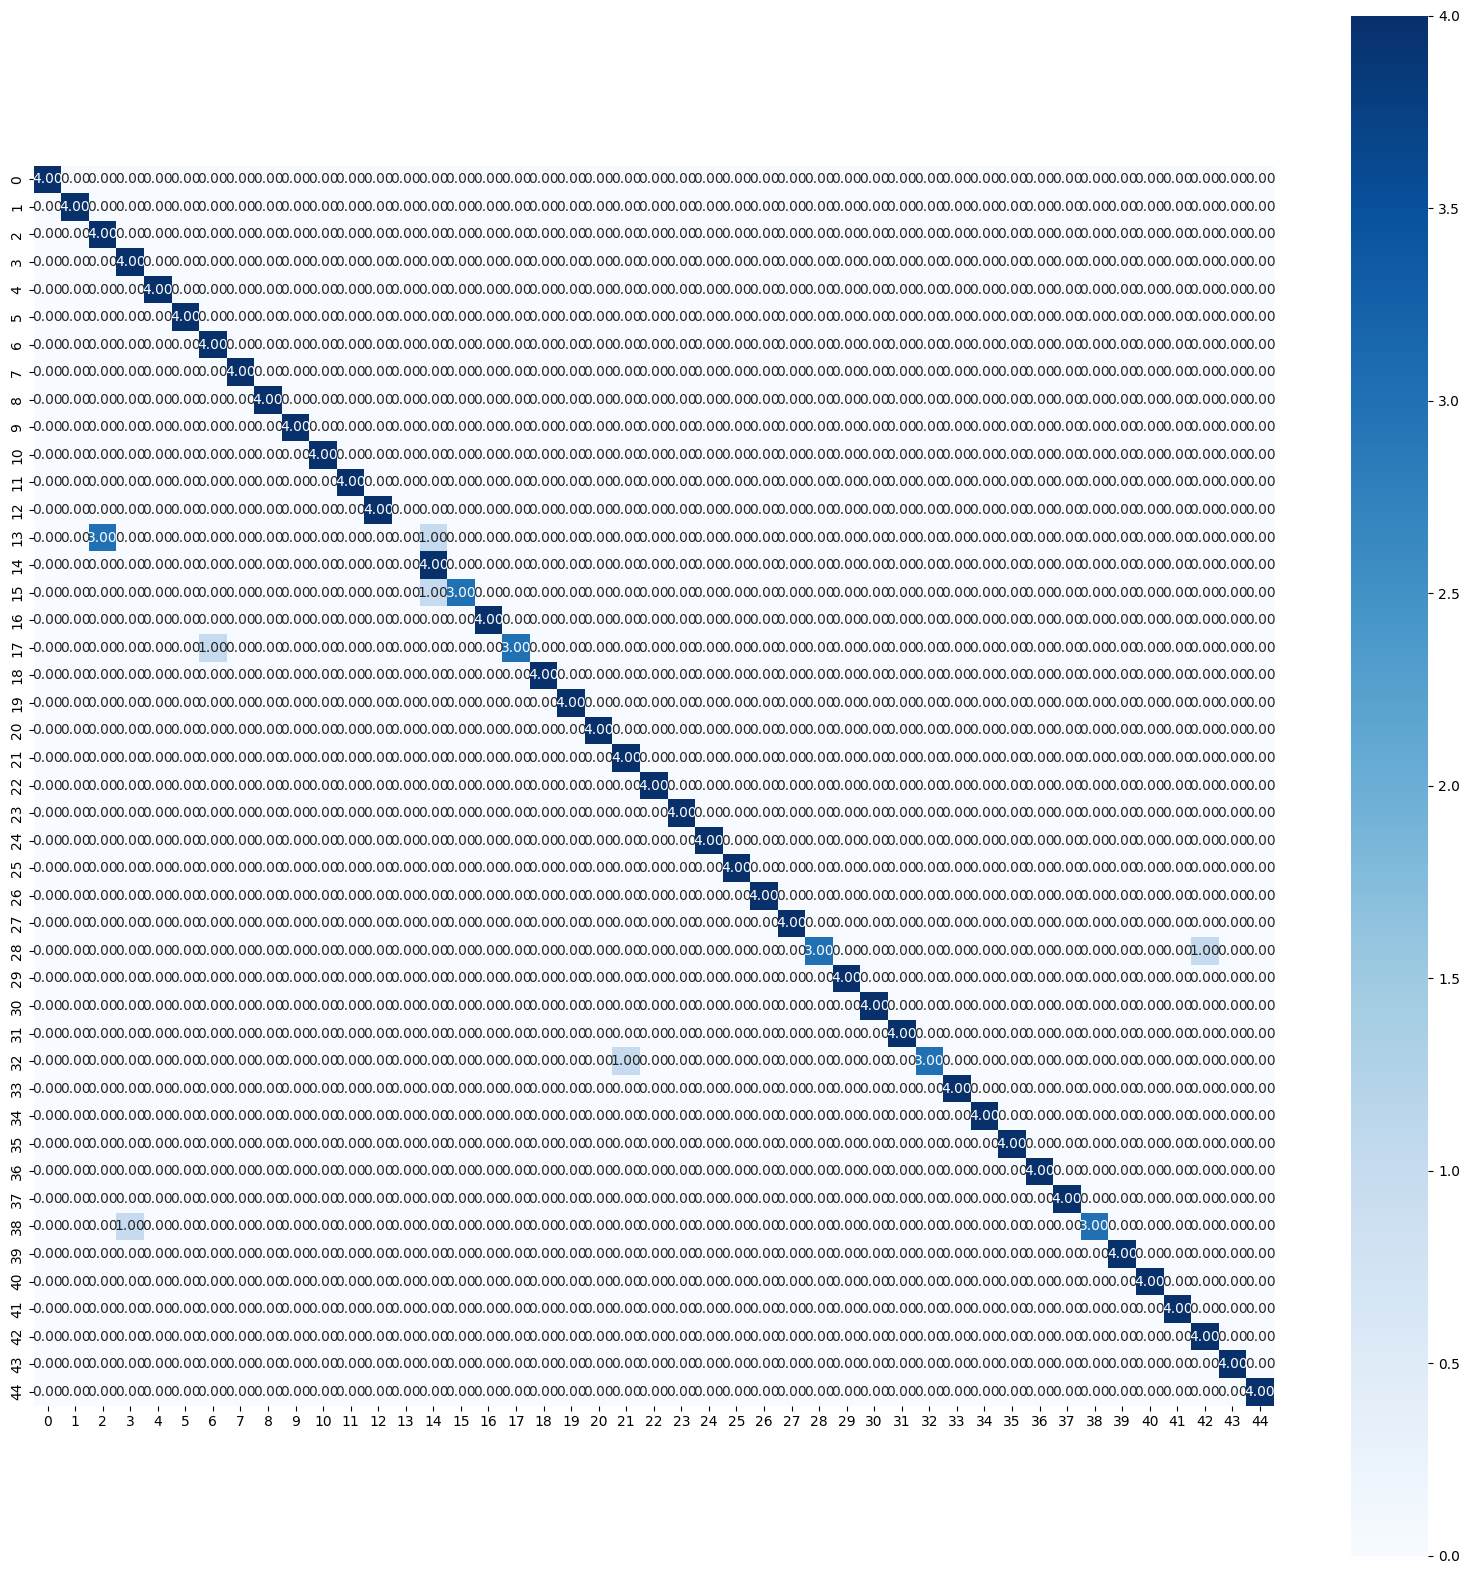

In [34]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_right_test_aug), np.array(y_right_test_pred))
plt.subplots(figsize=(20,20))
sns.heatmap(conf_matrix , annot=True,cmap='Blues', fmt=".2f")

# # Calcul des mesures de performance
accuracy = accuracy_score(y_right_test_aug, y_right_test_pred)
precision = precision_score(y_right_test_aug, y_right_test_pred,average='macro')
recall = recall_score(y_right_test_aug, y_right_test_pred,average='macro')
f1 = f1_score(y_right_test_aug, y_right_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

## Sauvegarde du modèle, de l'encodeur, de la data augmentation pour la reconnaisance de l'oeil droit

In [35]:
joblib.dump(X_right_train_aug,"/kaggle/working/img_right_train.joblib")
joblib.dump(X_right_test_aug,"/kaggle/working/img_right_test.joblib")

['/kaggle/working/img_right_test.joblib']

In [36]:
OD_model.save("/kaggle/working/vgg16_side_OD2ID_classif")
joblib.dump(labelRightEnc,"/kaggle/working/encodeur_OD.joblib")

['/kaggle/working/encodeur_OD.joblib']

# Détermination de l'orientation de l'oeil

## Récupération des images et préparation du dataset pour déterminer le côté de l'oeil

In [37]:
X, Y = liste_X_Y_side(main_folder, ['left', 'right'], img_dim)

In [38]:
labelEnc=preprocessing.LabelEncoder()
Y_enc=labelEnc.fit_transform(Y)

In [39]:
# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42, stratify=Y_enc)

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

In [40]:
print(len(X_train))
pd.Series(y_train).value_counts()

360


1    180
0    180
Name: count, dtype: int64

In [41]:
print(len(X_test))
pd.Series(y_test).value_counts()

90


1    45
0    45
Name: count, dtype: int64

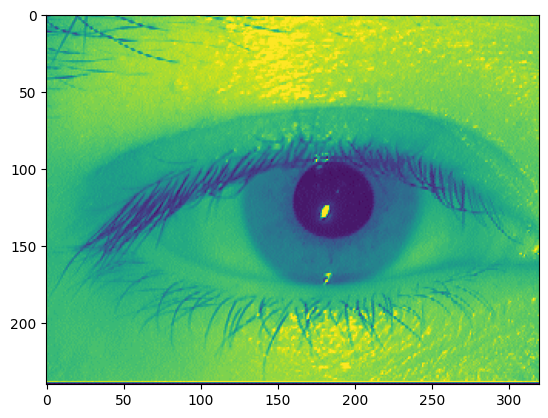

In [42]:
plt.imshow(X_train[0][:,:,2])

In [43]:
# data augmentation
datagen_2O = ImageDataGenerator(
    rotation_range=5,  # rotation
    width_shift_range=0.02,  # déplacement horizontal
    height_shift_range=0.02,  # déplacement vertical
    zoom_range=0.2,  # zoom
    brightness_range=(0.8, 1.2),  # luminosité
    fill_mode='nearest',  # mode de remplissage
)

aug_X_train, aug_y_train = data_augmentation(datagen_2O, X_train, y_train_enc, 5)

X_train_aug = X_train.copy()
y_train_aug = y_train_enc.copy()

for i in range(len(aug_X_train)):
  X_train_aug.append(aug_X_train[i])
  y_train_aug = np.concatenate((y_train_aug, np.array([aug_y_train[i]])))

In [44]:
print('X_train', len(X_train))
print('X_train_aug', len(X_train_aug))
print('y_train_enc', len(y_train_enc))
print('y_train_aug', len(y_train_aug))

X_train 360
X_train_aug 2160
y_train_enc 360
y_train_aug 2160


In [45]:
metric_stop = 'val_accuracy'
rlrop = ReduceLROnPlateau(monitor=metric_stop, factor=0.1, patience=3)
early = EarlyStopping(monitor=metric_stop,patience=5,restore_best_weights=True)

In [46]:
NBCLASSES = 2
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

O2_model = create_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

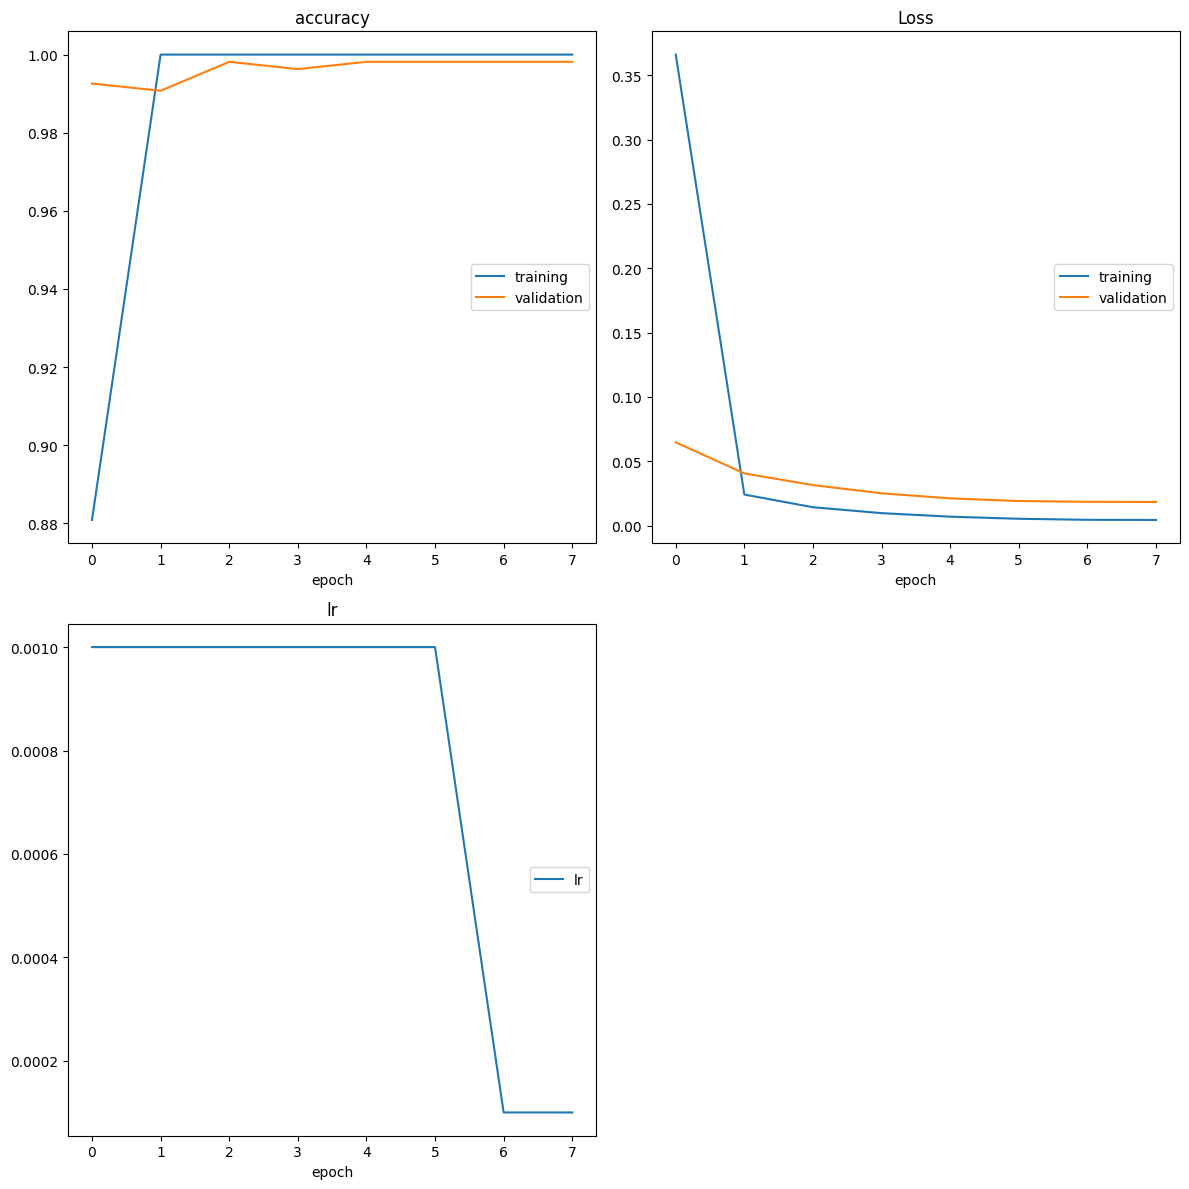

accuracy
	training         	 (min:    0.881, max:    1.000, cur:    1.000)
	validation       	 (min:    0.991, max:    0.998, cur:    0.998)
Loss
	training         	 (min:    0.004, max:    0.366, cur:    0.004)
	validation       	 (min:    0.018, max:    0.065, cur:    0.018)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
54/54 [==============================] - 16s 292ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9981 - lr: 1.0000e-04


In [47]:
hist = O2_model.fit(np.array(X_train_aug), np.array(y_train_aug), batch_size=30,
                    epochs=100, validation_split=0.25, callbacks=[rlrop, early, PlotLossesKeras()])

In [48]:
aug_X_test, aug_y_test = data_augmentation(datagen_2O, X_test, y_test, 4)

X_test_aug = X_test.copy()
y_test_aug = y_test.copy()

for i in range(len(aug_X_test)):
  X_test_aug.append(aug_X_test[i])
  y_test_aug = np.concatenate((y_test_aug, np.array([aug_y_test[i]])))

y_test_pred = [np.argmax(v) for v in O2_model.predict(np.array(X_test_aug))]  # Prédictions du modèle

15/15 [==============================] - 4s 259ms/step


In [49]:
print('X_test',len(X_test))
print('X_test_aug',len(X_test_aug))
print('y_test',len(y_test))
print('y_test_aug',len(y_test_aug))

X_test 90
X_test_aug 450
y_test 90
y_test_aug 450


Matrice de confusion :
[[223   2]
 [  0 225]]
Précision : 1.00
Rappel : 1.00
Score F1 : 1.00
Exactitude : 1.00


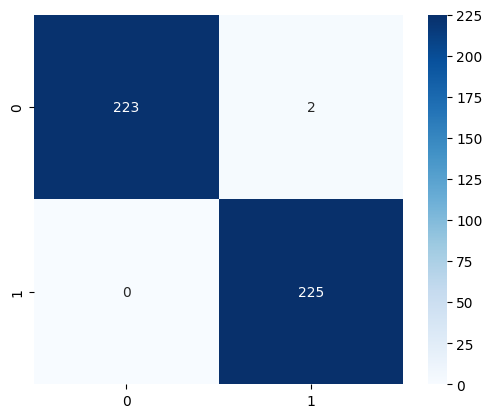

In [50]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test_aug), np.array(y_test_pred))
sns.heatmap(conf_matrix , annot=True,cmap='Blues', fmt="d")

# # Calcul des mesures de performance
accuracy = accuracy_score(y_test_aug, y_test_pred)
precision = precision_score(y_test_aug, y_test_pred,average='macro')
recall = recall_score(y_test_aug, y_test_pred,average='macro')
f1 = f1_score(y_test_aug, y_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

In [51]:
joblib.dump(X_train_aug,"/kaggle/working/img_train.joblib")
joblib.dump(X_test_aug,"/kaggle/working/img_test.joblib")

['/kaggle/working/img_test.joblib']

In [52]:
O2_model.save("/kaggle/working/vgg16_side_O2ID_classif")
joblib.dump(labelEnc,"/kaggle/working/encodeur_2O.joblib")

['/kaggle/working/encodeur_2O.joblib']